# Classification

A common task in computational research is to classify an object based on a set of features. In superivsed machine learning, we can give an algorithm a dataset of training examples that say "here are specific features, and this is the target class it belongs to". With enough training examples, a model can be built that recognizes important features in determining an objects class. This model can then be used to predict the class of an object given its known features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## 1) TelCo Dataset



We're going to load in the [telco customer dataset](https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset). Our goal here is to predict customer churn (whether or not customers leave a company's customer base) using information about the customers' behavior.

**Data Dictionary**

7043 observations with 20 variables

CustomerID: A unique ID that identifies each customer.

Gender: The customer’s gender: Male, Female.

Senior Citizen: Indicates if the customer is 65 or older: Yes, No

Partner: Indicate if the customer has a partner: Yes, No

Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

tenure: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No

Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No

Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.

Churn: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

In [2]:
churn = pd.read_csv("telco_churn.csv", index_col=[0])
churn.head()

,phoneservice,internetservice,onlinesecurity,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,churn,tenure,monthlycharges
customerID,,,,,,,,,,,,
7590-VHVEG,No,DSL,No,No,No,No,Month-to-month,Yes,Electronic check,No,1,29.85
5575-GNVDE,Yes,DSL,Yes,No,No,No,One year,No,Mailed check,No,34,56.95
3668-QPYBK,Yes,DSL,Yes,No,No,No,Month-to-month,Yes,Mailed check,Yes,2,53.85
7795-CFOCW,No,DSL,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,45,42.30
9237-HQITU,Yes,Fiber optic,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,2,70.70


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   phoneservice      7032 non-null   object 
 1   internetservice   7032 non-null   object 
 2   onlinesecurity    7032 non-null   object 
 3   techsupport       7032 non-null   object 
 4   streamingtv       7032 non-null   object 
 5   streamingmovies   7032 non-null   object 
 6   contract          7032 non-null   object 
 7   paperlessbilling  7032 non-null   object 
 8   paymentmethod     7032 non-null   object 
 9   churn             7032 non-null   object 
 10  tenure            7032 non-null   int64  
 11  monthlycharges    7032 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 714.2+ KB


We have 11 independent variables and one target variable: `Churn`.

Two of our independent variables are numeric, while the nine others are categorical.

Let's get to know our dataset by conducting some exploratory data analysis. We'll be using some rudimentary data analysis to see there's a relationship between the independent variables and churn.

In [9]:
churn.groupby("churn").mean()

,tenure,monthlycharges
churn,,
No,37.650010,61.307408
Yes,17.979133,74.441332


**Does this tell us anything informative?**

## 2) Logistic Regression

Logistic regression is a supervised classification algorithm that is used to predict a binary outcome. Similar to linear regression, this model uses coefficients or betas to make its predictions. However unlike a linear regression, its predictions do not fit a straight line but rather a curve known as the Sigmoid Curve as show in the following image.

![](https://miro.medium.com/max/700/1*44qV8LhNzE5hPnta2PaaHw.png)

In this chart, the x-axis represents the feature and the y-axis represents the probability of the red class 1 dots. Class predictions are made based on whether or a probability meets or surpasses the 0.5 probability threshold.


### Sigmoid Formula

$\LARGE\Pr(Y_i=1|X_i) = {\frac1{1 + exp (-(\beta_0 + \beta_1X_i + \beta_2X_2 + \beta_3X_3))}}$



### Interpreting the Logistic Regression Coefficients


![](https://miro.medium.com/max/1400/1*aPgytc42C1btLtB3YbFTQA.jpeg)


Our task now is to the logistic regression model to classify churn.

### Null accuracy

One of the first things you need to check in a classification project is the **null accuracy**.

This is defined as the proportion of the largest class in the target variable.

In [4]:
# Assign y variable
y = churn.churn

#Grab proporition
y.value_counts(normalize =True)

No     0.734215
Yes    0.265785
Name: churn, dtype: float64

- The largest class is `No` which makes up almost 3/4 of the data.
- The null accuracy is important because it serves as a benchmark for our model. 
- Let's say we were to train a "dummy" model that simply predicted "No" everytime because "No" is the largest class.
- That would mean we'd have a model that's correct 73.4% of the time without doing any actual model training.
- That would also mean that an actual trained model that produced a 75 or 76% accuracy wouldn't be that good of a model because it barely beats the "dummy" model.

Let's train a logistic regression model on the two quantitative variables: `monthlycharges` and `tenure`

In [5]:
#Select just the numerical columns
X_num =churn.select_dtypes("number")
X_num.head()

,tenure,monthlycharges
customerID,,
7590-VHVEG,1,29.85
5575-GNVDE,34,56.95
3668-QPYBK,2,53.85
7795-CFOCW,45,42.30
9237-HQITU,2,70.70


In [6]:
#Convert No -> 0 and Yes -> 1. Follows alphanumeric ordering
y = y.factorize()[0]

#Initialize model
lr = LogisticRegression()
#Fit on data
lr.fit(X_num, y)

LogisticRegression()

In [7]:
#Accuracy score
lr.score(X_num, y)

0.7842718998862344

### Probability Decision Boundary Plot

Let's visualize the logistic regression model. And what we mean by visualize is we're going to plot a 2-d plot that color-encodes the probailities of the the two classes.

- Red shaded areas indicate the not churn
- Blue shaded areas indicate churn
- Shading corresponds to prediction strength

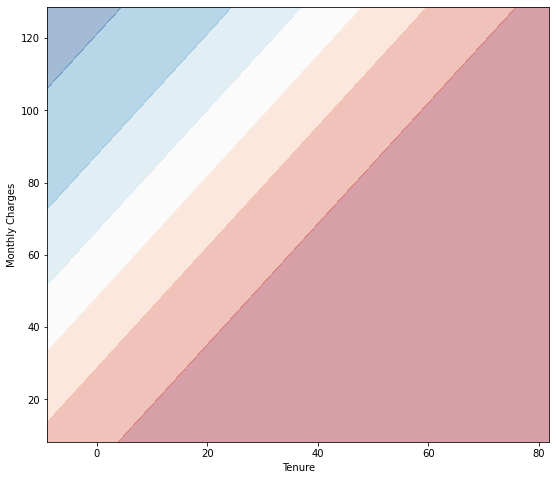

In [8]:
min1, max1 = X_num.iloc[:, 0].min()-10, X_num.iloc[:, 0].max()+10
min2, max2 = X_num.iloc[:, 1].min()-10, X_num.iloc[:, 1].max()+10
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
yhat = lr.predict_proba(grid)[:, 1]
zz = yhat.reshape(xx.shape)
plt.figure(figsize=(9, 8))
plt.contourf(xx, yy, zz, cmap='RdBu', alpha = .4)
plt.xlabel("Tenure")
plt.ylabel("Monthly Charges");

### One-Hot-Encoding

Time to train a model using the categorical variables. We obviously cannot throw directly them into a model, we need to do a form of preprocessing called one-hot encoding that turns categorical data into numerical data.

One-hot-encoding creates `k` new variables for a single categorical variable with `k` categories (or levels), where each new variable is coded with a `1` for the observations that contain that category, and a `0` for each observation that doesn't. 

We're going to learn hot to create these variables with both pandas and sklearn.

Making dummy variables in pandas

In [9]:
#Pick PaymentMethod variable

pm = churn.paymentmethod
pm.head()

customerID
7590-VHVEG             Electronic check
5575-GNVDE                 Mailed check
3668-QPYBK                 Mailed check
7795-CFOCW    Bank transfer (automatic)
9237-HQITU             Electronic check
Name: paymentmethod, dtype: object

In [10]:
#Show unique categories in paymentmethod
pm.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

`paymentmethod` has four unique variables which means we are going to create a dummy variable dataframe with four columns

In [11]:
pm_dummies = pd.get_dummies(pm, prefix="paymentmethod_")
pm_dummies.head()

,paymentmethod__Bank transfer (automatic),paymentmethod__Credit card (automatic),paymentmethod__Electronic check,paymentmethod__Mailed check
customerID,,,,
7590-VHVEG,0,0,1,0
5575-GNVDE,0,0,0,1
3668-QPYBK,0,0,0,1
7795-CFOCW,1,0,0,0
9237-HQITU,0,0,1,0


`pd.get_dummies` can be used on the entire dataset

In [12]:
#Grab categorical columns, referred to as object by pandas


o_cols = churn.select_dtypes("object").columns[:-1] # [:-1] is for excluding the target variable churn 
churn_dummies = pd.get_dummies(churn, columns=o_cols)
churn_dummies.head()

,churn,tenure,monthlycharges,phoneservice_No,phoneservice_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_No,onlinesecurity_No,onlinesecurity_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,No,1,29.85,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5575-GNVDE,No,34,56.95,0,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
3668-QPYBK,Yes,2,53.85,0,1,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
7795-CFOCW,No,45,42.30,1,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,0,0
9237-HQITU,Yes,2,70.70,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


**Dummy Variable Trap section**

The ["Dummy Variable Trap"](https://www.algosome.com/articles/dummy-variable-trap-regression.html) occurs when using One-Hot-Encoding on multiple categorical variables within the same set of features. This is because each set of one-hot-encoded variables can be added together across columns to create a single column of all `1`s, and so are multi-colinear when multiple one-hot-encoded variables exist within a given model.

To resolve this,we remove the first one-hot-encoded variable for each categorical variables, resulting in `k-1` so-called "Dummy Variables". 

In pandas we can address the dummy variable trap issue by setting `drop_first` to `True`

In [13]:
#Make dummy variables for phoneservice
pd.get_dummies(churn.phoneservice, prefix="phoneservice_", drop_first=True).head()

,phoneservice__Yes
customerID,
7590-VHVEG,0
5575-GNVDE,1
3668-QPYBK,1
7795-CFOCW,0
9237-HQITU,1


Remember it's unneccesary for each of the two categories in phoneservices to have each own's column.

Even though "No" isn't in the dataframe above, it's still represented in the data by virtue of the 0 value under the `phoneservice__Yes` column.

Repeat process for entire set of dummy variables

In [14]:
churn_dummies = pd.get_dummies(churn, columns=o_cols, drop_first=True)
churn_dummies.head()

,churn,tenure,monthlycharges,phoneservice_Yes,internetservice_Fiber optic,internetservice_No,onlinesecurity_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,No,1,29.85,0,0,0,0,0,0,0,0,0,1,0,1,0
5575-GNVDE,No,34,56.95,1,0,0,1,0,0,0,1,0,0,0,0,1
3668-QPYBK,Yes,2,53.85,1,0,0,1,0,0,0,0,0,1,0,0,1
7795-CFOCW,No,45,42.30,0,0,0,1,1,0,0,1,0,0,0,0,0
9237-HQITU,Yes,2,70.70,1,1,0,0,0,0,0,0,0,1,0,1,0


In [15]:
#Number of features is reduced from 25 to 16
churn_dummies.shape

(7032, 16)

### Sci-kit Learn way

Initialize the one hot encoder object. 

Set drop = 'first' to avoid dummy variable trap.

In [18]:

ohe = OneHotEncoder(categories='auto', handle_unknown='error', sparse=False, drop="first")

In [19]:
#Fit transform on the paymentmethod variable
pm = churn[["paymentmethod"]]
pm_ohe = ohe.fit_transform(pm)
pm_ohe.shape

(7032, 3)

In [20]:
#Fit transform on the object columns variable
o_cols = churn.drop("churn", axis = 1).select_dtypes("object")

churn_ohe = ohe.fit_transform(o_cols)
churn_ohe.shape

(7032, 13)

In [24]:
#Make it dataframe
churn_ohe = pd.DataFrame(index=churn.index, data=churn_ohe, columns=ohe.get_feature_names())
churn_ohe.head()

,x0_Yes,x1_Fiber optic,x1_No,x2_Yes,x3_Yes,x4_Yes,x5_Yes,x6_One year,x6_Two year,x7_Yes,x8_Credit card (automatic),x8_Electronic check,x8_Mailed check
customerID,,,,,,,,,,,,,
7590-VHVEG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5575-GNVDE,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3668-QPYBK,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7795-CFOCW,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9237-HQITU,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Now let's join this with numerical data

In [26]:
#Concatenate X_num and with churn_ohe.
#Set axis = 1 to do a side by side concatenation
X = pd.concat([X_num, churn_ohe], axis = 1)
X.head()

,tenure,monthlycharges,x0_Yes,x1_Fiber optic,x1_No,x2_Yes,x3_Yes,x4_Yes,x5_Yes,x6_One year,x6_Two year,x7_Yes,x8_Credit card (automatic),x8_Electronic check,x8_Mailed check
customerID,,,,,,,,,,,,,,,
7590-VHVEG,1,29.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5575-GNVDE,34,56.95,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3668-QPYBK,2,53.85,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7795-CFOCW,45,42.30,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9237-HQITU,2,70.70,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


**Now we are ready to do some modeling**

### Modeling with Logistic Regression

Before we train our model we have to do a train test split.

- We use test size of 25%
- Set stratify = y to produce the same class proportions in both datasets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify=y)

1. Initialize Model
2. Fit model on training data
3. Evaluate on training and testing datasets

In [28]:
lr = LogisticRegression(max_iter=170)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=170)

In [29]:
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print("Training score = {}, testing score = {}".format(train_score.round(3), test_score.round(3)))

Training score = 0.798, testing score = 0.802


**How well did we do? Is the model overfit?**

However, we've only done a single train test split, there could be bias in how we split the data so we need to execute multiple splits and trainings to make sure our results are representative of what we're trying to model.

This is referred to as kfold cross-validation.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [30]:
#Initialize KFold object with
kf = KFold(n_splits=5)

#Run cross_val_score function
cv_results = cross_val_score(LogisticRegression(max_iter=400), X, y, cv=kf, scoring="accuracy")
cv_results


array([0.80454869, 0.80597015, 0.78733997, 0.79943101, 0.79587482])

In [31]:
cv_results.mean()

0.7986329276195734

**What does this tell us about the performance of our model?**

#### Model Interpretation

Let's look at the coefficients to understand what affects churn.

In [32]:
#Retrain model

lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [33]:
#Here's how to grab the coefficients
lr.coef_

array([[-0.03293799,  0.01200578, -0.68066802,  0.66250061, -0.59698269,
        -0.49938764, -0.424693  ,  0.16909197,  0.11593115, -0.76832998,
        -1.35036354,  0.35516166, -0.04772461,  0.29194219, -0.03643844]])

Organize the coefficients and feature names into a pandas series

In [34]:
coef = pd.Series(index= X.columns, data=lr.coef_[0])

In [35]:
#Sort coef from least to greatest
coef.sort_values()

x6_Two year                  -1.350364
x6_One year                  -0.768330
x0_Yes                       -0.680668
x1_No                        -0.596983
x2_Yes                       -0.499388
x3_Yes                       -0.424693
x8_Credit card (automatic)   -0.047725
x8_Mailed check              -0.036438
tenure                       -0.032938
monthlycharges                0.012006
x5_Yes                        0.115931
x4_Yes                        0.169092
x8_Electronic check           0.291942
x7_Yes                        0.355162
x1_Fiber optic                0.662501
dtype: float64

Observations:

- A two year contract is the feature most associated not churning.
- Having fiber optic internet is the feature most associated with churning.

#### Model evaluation

We've covered accuracy already but there a whole litany of other ways to evaluate the performance of a classification model.

$$ Accuracy= \frac{\sum{\text{True Positives}}+\sum{\text{True Negatives}}}{\sum{\text{Total Population}}}$$

#### Confusion Matrix


<img src='https://www.dataschool.io/content/images/2015/01/confusion_matrix2.png' width=500>



[Confusion Matrix (Wikipedia)](https://en.wikipedia.org/wiki/Confusion_matrix): 
- true positive (TP): A test result that correctly indicates the presence of a condition or characteristic
- true negative (TN): A test result that correctly indicates the absence of a condition or characteristic
- false positive (FP): A test result which wrongly indicates that a particular condition or attribute is present
- false negative (FN): A test result which wrongly indicates that a particular condition or attribute is absent

### Challenge

Write down what are TP, TN, FP, and FN of the telco churn dataset

Answer:
    
- TP are customers who churn that the model predicted to churn.
- TN are customers who did not churn that the model predicted to not churn.
- FP are customers who did not churn that the model predicted to churn.
- FN are customers who did churn that the model predicted to not churn.


1. **Precision**: 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Predicted Positives}}}$$
2. **Recall** (or **Sensitivity**): 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Condition Positives}}}$$ 
3. **Specificity** (like recall for negative examples): 
$$\frac{\sum{\text{True Negatives}}}{\sum{\text{Condition Negatives}}}$$




<img src='https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg' width=400, height = 300>

Let's make a confusion matrix and derive the recall and precision scores.

First let's make predictions from the test dataset

In [37]:
preds = lr.predict(X_test)

In [38]:
#Pass y_test and preds into confusion_matrix

confusion_matrix(y_test, preds)

array([[1162,  129],
       [ 208,  259]])

How many TP, TN, FN, and FP are there?

Recall score

In [39]:
recall_score(y_test, preds)

0.5546038543897216

Precision score

In [40]:
precision_score(y_test, preds)

0.6675257731958762

**Which score is more important in this scenario?**


**Imagine a model that produced scores that were switched, which model is the better one?**

#### F1 Score

![](https://images.deepai.org/glossary-terms/b9c8dec8549a4201ae358483cc6bdfa6/fscore.jpg)

In [41]:
f1_score(y_test, preds)

0.6058479532163742

## 2) Decision Trees

![](https://static01.nyt.com/images/2008/04/16/us/0416-nat-subOBAMA.jpg)

#### Sci-kit learn decision tree example

![](https://www.kdnuggets.com/wp-content/uploads/dt-iris-interpretability.jpg)

**Decision Trees** are a classification/regression supervised learning algorithm that uses a series of splits to make its predictions.

Decision Trees learn from the data by picking the feature-threshold that maximizes the information gain of the target variable. In other words it chooses a splitting point that produces the most imbalanced/pure proportions in the target variable. The goal of the model is to keep splitting until all the data in a terminal node or leaf are exclusively one class.

The information gain is measured with either of the following formulas

![](https://miro.medium.com/max/884/1*efLrD1ECWl-utII0KYb7tQ.jpeg)

![](https://miro.medium.com/max/884/1*vRlwRFknvfgWLBed1vsGoQ.jpeg)

The model iterates through a set of values for each feature and then calculate the information gain for each split and the one that produces the lowest value is the designated split.

**Parameters**

criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

splitter: The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

min_samples_split: The minimum number of samples required to split an internal node

min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

max_features: The number of features to consider when looking for the best split

Now let's train a decision tree model on the TelCo Churn dataset.

We are going to initialize a default DT model, meaning we're not going to pass in any parameters of our own.

And like we did before, we are going to fit a model and then evaluate it on the training and testing datasets

In [43]:
#Initialize model
dt = DecisionTreeClassifier()

#Fit model on the dataset
dt.fit(X_train, y_train)

#Derive the training accuracy score
dt.score(X_train, y_train)

0.9952597648843383

**Woohoo we got near perfect model!!!**

Or did we......??? (Hint: we didn't)

In [65]:
#testing score
dt.score(X_test, y_test)

0.7258248009101251

Our testing score is considerably lower. 

Remember the point of a machine learning model is to keep a machine learning model. We want to be confident that when we apply our model in the real world it will do a decent job of evaluating data it has not seen before.

Now let's try a model in which we impose a `max_depth` in order to prune the tree. 

In [66]:
#Initialize
dt = DecisionTreeClassifier(max_depth =5)
# Fit 
dt.fit(X_train, y_train)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.805 and our testing score is 0.772


The gap between the two scores is considerably lower. We arguably don't have an overfit model anymore.

Let's see how min_samples_leaf impacts the overfitness of the model

In [67]:
X.columns

Index(['tenure', 'monthlycharges', 'phoneservice_Yes',
       'internetservice_Fiber optic', 'internetservice_No',
       'onlinesecurity_Yes', 'techsupport_Yes', 'streamingtv_Yes',
       'streamingmovies_Yes', 'contract_One year', 'contract_Two year',
       'paperlessbilling_Yes', 'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [68]:
#Initialize
dt = DecisionTreeClassifier(min_samples_leaf = 20)
# Fit 
dt.fit(X_train, y_train)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print("Our training score is {} and our testing score is {}".format(train_score.round(3), test_score.round(3)))

Our training score is 0.824 and our testing score is 0.773


### Tree Visualization

We are going to visualize the actual decision tree.


Let's retrain it with a small `max_depth` 

In [69]:
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

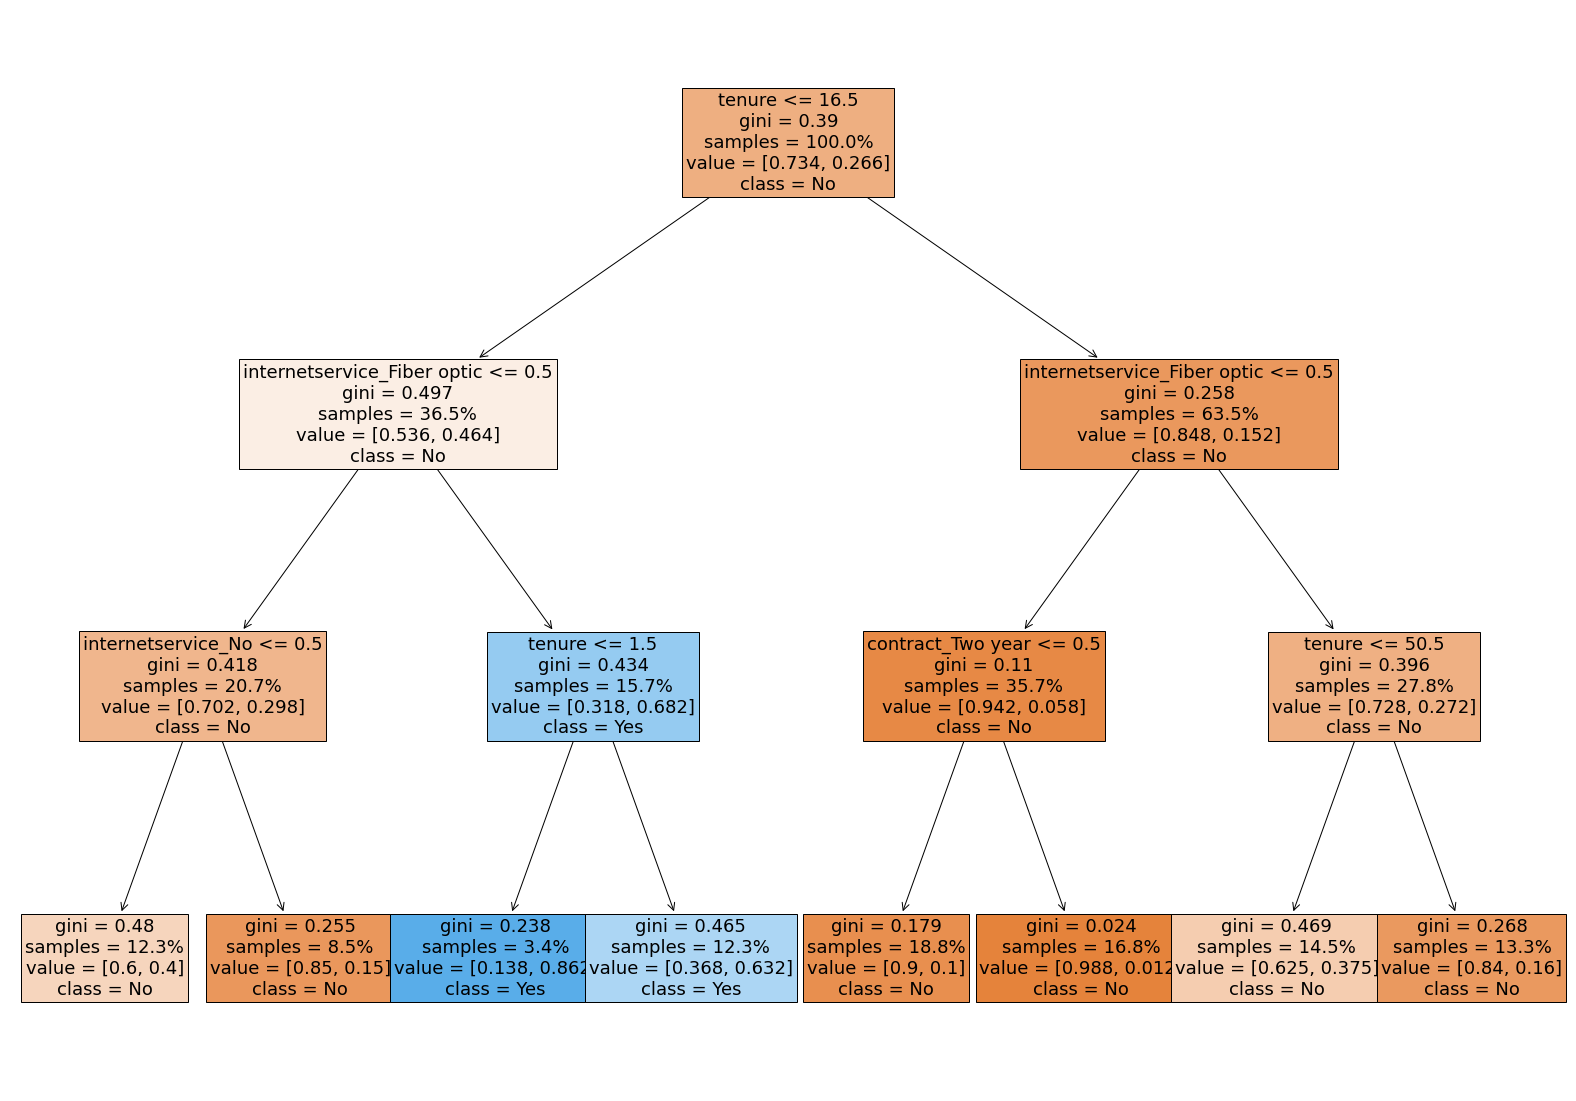

In [74]:
plt.figure(figsize=(28, 20))
plot_tree(dt, feature_names=X.columns, class_names=["No", "Yes"], 
          filled = True, proportion=True, fontsize=18
         );

**What does the tree tell us about patterns in the data**

Using the tree, how would we make predictions about the following customers?


    - Customer A: Been a customer for 20 months, does have fiber optic internet and is on a two year contract.
    - Customer B: Been a customer for 10 months and has fiber optic internet